# Module3: Julie Vuadens et Hoa-Ai Béatrice Hua
## Sod's shock tube

# Programme 

Dans ce module, nous étudions le problème du shock tube.
<br />Le cas consiste en un tube séparé en deux compartiments par une membrane amovible, les conditions initiales de pression, vitesse et densité étant différentes dans chacun des compartiments. A l'instant t=0, la membrane est enlevée et ce programme a pour but d'analyser l'évolution de ces grandeurs physique à travers le temps.
<br />Afin d'analyser le comportement du gaz, nous allons utiliser les équations d'Euler suivantes :
<br />$$\frac{\partial\rho}{\partial t}+\frac{\partial (\rho u)}{\partial x}=0$$
<br />$$\frac{\partial \rho u}{\partial t}+\frac{\partial (\rho u^2+p)}{\partial x}=0$$
<br />$$\frac{\partial \rho e_T}{\partial t}+\frac{\partial (\rho e_T+p)*u}{\partial x}=0$$
<br />avec $$e_T = \frac{\rho}{(\gamma-1)p} + \frac{1}{2}u^2$$
<br />Pour commencer, nous importons les bibliothèques et commandes nécessaires à l'exécution de notre programme.

In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
from matplotlib import animation
from IPython.display import HTML

Nous imposons les paramètres de code consignés.
<br />dt est le pas de temps
<br />Nous désirons connaitre la pression, la densité et la vitesse à $t=0.01 s$
<br />Puisque $t = nt \ dt$ on doit prendre la valeur $nt=51$

Nous devons effectuer 51 étapes et non 50 car la première étape que nous introduisons dans notre méthode de richtmyer correspond au temps $t=0.0s$, nous devons donc effectuer un pas supplémentaire pour arriver à l'instant souhaité.

In [2]:
dt = 0.0002
nx = 81
dx = 0.25 
gamma=1.4
nt=51

Nous créons maintenant un tableau de 81 valeurs de x, espacées de $dx=0.25m$ et qui vont de -10m à +10m 

In [3]:
x=numpy.linspace(-10,10,nx)
print x

[-10.    -9.75  -9.5   -9.25  -9.    -8.75  -8.5   -8.25  -8.    -7.75
  -7.5   -7.25  -7.    -6.75  -6.5   -6.25  -6.    -5.75  -5.5   -5.25  -5.
  -4.75  -4.5   -4.25  -4.    -3.75  -3.5   -3.25  -3.    -2.75  -2.5
  -2.25  -2.    -1.75  -1.5   -1.25  -1.    -0.75  -0.5   -0.25   0.     0.25
   0.5    0.75   1.     1.25   1.5    1.75   2.     2.25   2.5    2.75   3.
   3.25   3.5    3.75   4.     4.25   4.5    4.75   5.     5.25   5.5
   5.75   6.     6.25   6.5    6.75   7.     7.25   7.5    7.75   8.     8.25
   8.5    8.75   9.     9.25   9.5    9.75  10.  ]


Nous introduisons maintenant les conditions initiales dans le tube à gauche et à droite à l'instant $t=0.0s$ sur la pression, la vitesse et la densité.

In [4]:
rho0 = numpy.zeros(nx)
u0 = numpy.zeros(nx)
p0 = numpy.zeros(nx)
#la densité:
rho0[:40]=1. #kg/m**3
rho0[40:]=0.125 #kg/m**3
#la vitesse:
u0[:]=0. #m/s
#la pression:
p0[:40]=100000. #N/m**2
p0[40:]=10000.  #N/m**2

Nous allons créer le vecteur H. On le renomme ainsi afin qu'il n'y ait pas de confusion entre le vecteur $\underline{\mathbf{u}}$ et la vitesse u utilisé dans l'énoncé. Pour cela, nous introduisons la fonction computeH qui dépend de rho (la densité), u (la vitesse) et p(la pression).
<br />Cette fonction renvoie le vecteur $\underline{\mathbf{H}}$: $$\underline{\mathbf{H}}=(\rho,\rho u , \rho (\frac{p}{(\gamma-1)\rho} + \frac{1}{2} u^2)) = (\rho,\rho u , \rho e_T)$$

In [5]:
def computeH(rho,u,p):
    H=numpy.array([rho,rho*u,rho*(p/((gamma-1.)*rho)+0.5*u**2)])
    return H

A présent, les conditions initiales énoncées auparavent et la fonction computeH nous permettent d'obtenir le vecteur $H$ au temps $t=0.0s$ 

In [6]:
h0 = computeH(rho0,u0,p0)

Définissons maintenant la fonction computeF qui dépend du vecteur $H$ que nous venons de calculer. Cela nous permet d'obtenir F qui est tel que : $$F = (\rho u , \rho u^2 +p,(\rho e_T + p) u)$$

In [7]:
def computeF(H):
    F=numpy.array((H))
    F[0]=H[1]
    F[1]=H[1]**2/H[0] + ((gamma-1.) * ( H[2]-0.5*H[1]**2/H[0]))
    F[2]=(H[2]+((gamma-1.)*(H[2]-0.5*H[1]**2/H[0])))*(H[1]/H[0])
    return F

# Implémentation de la méthode de richtmyer

A présent, nous implémentons la méthode de richtmyer imposée afin d'obtenir l'évolution temporelle et spatiale du gaz dans le shock tube. Elle consiste en 2 étapes: $$\begin{align}predictor :
\underline{\mathbf{u}}^{n+\frac{1}{2}}_{i+\frac{1}{2}} = \frac{1}{2} \left( \underline{\mathbf{u}}^n_{i+1} + \underline{\mathbf{u}}^n_i \right) - \frac{\Delta t}{2 \Delta x} \left( \underline{\mathbf{f}}^n_{i+1} - \underline{\mathbf{f}}^n_i\right) \\
  corrector :\underline{\mathbf{u}}^{n+1}_i = \underline{\mathbf{u}}^n_i - \frac{\Delta t}{\Delta x} \left(\underline{\mathbf{f}}^{n+\frac{1}{2}}_{i+\frac{1}{2}} - \underline{\mathbf{f}}^{n+\frac{1}{2}}_{i-\frac{1}{2}} \right)
\end{align}$$
Avec : $$\underline{\mathbf{f}}^{n+\frac{1}{2}}_{i+\frac{1}{2}} = \underline{\mathbf{f}}\left(\underline{\mathbf{u}}^{n+\frac{1}{2}}_{i+\frac{1}{2}}\right).$$

In [8]:
def richtmyer(h0,dt,dx,nt,nx):
    h=h0.copy()
    predictor=numpy.zeros((3,nx-1))
    for i in range (1,nt):
        h_t=h.copy()
        F1=computeF(h)
        predictor[:,:]=0.5*(h[:,1:]+h[:,:-1])-0.5*(dt/dx)*(F1[:,1:]-F1[:,:-1]) #Predictor
        F2=computeF(predictor)
        h_t[:,1:-1]=h[:,1:-1]-(dt/dx)*(F2[:,1:]-F2[:,:-1])                     #Corrector
        h=h_t.copy()
    return h

Nous avons à présent un tableau $h$ à partir duquel nous construisons un autre tableau $sol$ dans lequel on aura isolé les quantités souhaitées ( densité $\rho$, vitesse $u$, pression $p$) évoluants en fonction de leurs positions correspondants aux colonnes du tableau. 

In [9]:
def solution(h):
    sol=numpy.zeros((3,nx))
    sol[0,:]=h[0,:]                                     #densité
    sol[1,:]=h[1,:]/h[0,:]                              #vitesse
    sol[2,:]=(h[2,:]-0.5*h[1,:]**2/h[0,:])*(gamma-1.)   #pression
    return sol

# Résultats:

Nous présentons en liste les valeurs numériques demandées dans les consignes calculées par notre programme.

##### 1°) densité du gaz à travers le tube à $0.01s$ 

In [10]:
r=richtmyer(h0,dt,dx,nt,nx)
s=solution(r)
print s[0]

[ 1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          0.99999997
  0.99999986  0.99999932  0.99999694  0.99998741  0.9999526   0.99983736
  0.99949289  0.99856792  0.99635019  0.99162823  0.98273521  0.96792076
  0.94600154  0.9168774   0.88164814  0.84208594  0.80012107  0.75730048
  0.71481491  0.67277761  0.63389053  0.59052577  0.56181242  0.51598546
  0.48995123  0.44887417  0.44760904  0.29696558  0.36126796  0.43359314
  0.42699377  0.41099442  0.41892596  0.44399618  0.46434585  0.45696901
  0.42194861  0.3746914   0.3317037   0.30204312  0.28704464  0.280923
  0.27230546  0.25570383  0.24516403  0.26061836  0.29707243  0.30148605
  0.2238121   0.14723687  0.12725797  0.1251773   0.12501369  0.12500107
  0.12500009  0.12500001  0.125       0.125       0.125       0.125       0.125
  0.125       0.125       0.125       0.125       0.125       0.125       0.125     ]


##### 2°) vitesse du gaz à travers le tube à $0.01s$ 

In [11]:
print s[1]

[  0.00000000e+00   0.00000000e+00   0.00000000e+00   2.32830644e-14
   5.93718141e-13   6.62403181e-12   6.57746568e-11   5.96523751e-10
   4.94139967e-09   3.74458963e-08   2.59932445e-07   1.65429166e-06
   9.65776191e-06   5.17246984e-05   2.54062673e-04   1.14361108e-03
   4.71164597e-03   1.77359360e-02   6.08552016e-02   1.89774009e-01
   5.36074302e-01   1.36730395e+00   3.14149526e+00   6.50070788e+00
   1.21482296e+01   2.06355514e+01   3.21545379e+01   4.65044421e+01
   6.31731620e+01   8.15703614e+01   1.01153787e+02   1.21552428e+02
   1.42422300e+02   1.63781363e+02   1.85296130e+02   2.07099150e+02
   2.29266667e+02   2.50686879e+02   2.72784782e+02   2.88746713e+02
   4.03996151e+02   3.47154191e+02   2.92990110e+02   2.91488445e+02
   2.93898519e+02   2.92738960e+02   2.93268647e+02   2.93124509e+02
   2.93062108e+02   2.92866153e+02   2.92611472e+02   2.92374472e+02
   2.93501646e+02   2.98028915e+02   3.03098379e+02   2.97518663e+02
   2.75662872e+02   2.60358897e+02

##### 3°) pression du gaz à travers le tube à $0.01s$ 

In [12]:
print s[2]

[ 100000.          100000.          100000.          100000.          100000.
  100000.           99999.99999998   99999.99999978   99999.99999815
   99999.99998599   99999.99990274   99999.99938102   99999.9963864
   99999.98064639   99999.90493847   99999.57210084   99998.23707557
   99993.36401521   99977.23222717   99929.01481945   99799.58960971
   99489.52486473   98830.43065018   97592.93675405   95541.9420249
   92530.56930434   88571.69130479   83847.96266205   78630.09327066
   73199.16419786   67772.33234716   62501.80539256   57445.37322175
   52694.37374187   48167.16829576   44053.64411186   40004.2180437
   36635.99923353   32990.57645207   31434.01202837   18297.14536249
   23853.90814686   30365.23647201   30559.26718229   30232.90128631
   30406.5626951    30364.7595012    30374.86233604   30333.26705019
   30297.34950958   30250.89016757   30217.0396725    30341.86600962
   30839.11115406   31388.81165424   30766.24947879   28477.12717262
   26974.91621314   29541.84

# Graphiques:

Nous dessinons les graphiques de la densité, la vitesse et la pression en fonction de la position dans le tube.


Nous allons définir des fonctions pour réaliser ces graphiques, afin de pouvoir étudier l'évolution temporelle par la suite.


On commence par évaluer au temps t=0.01s, c'est-à-dire pour nt=51.

In [13]:
def densite(rho):
    pyplot.figure(figsize=(7,4))
    pyplot.plot(x, rho, color='#003366', ls='-', lw=2)
    pyplot.ylim(0.0,1.2)
 
    pyplot.xlabel('x(m)', fontsize=14) 
    pyplot.ylabel('density (kg/m**3) ', fontsize=14) 
    pyplot.title('Density accross the tube at time t ',fontsize=18)

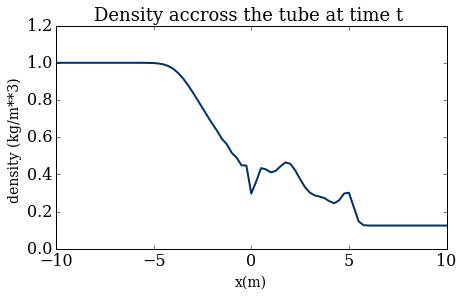

In [14]:
densite(s[0])

In [15]:
def vitesse(u):
    pyplot.figure(figsize=(7,4))
    pyplot.plot(x, u, color='#003366', lw=2)
    pyplot.ylim(0,450);
    pyplot.xlabel('x(m)', fontsize=14) 
    pyplot.ylabel('velocity (m/s) ', fontsize=14) 
    pyplot.title('Velocity accross the tube at time t ',fontsize=18)

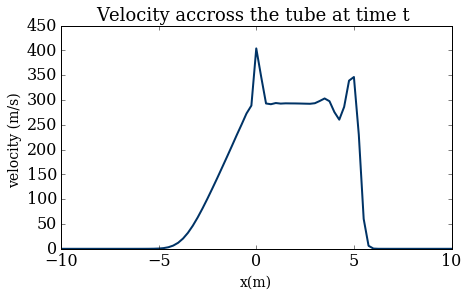

In [16]:
vitesse(s[1])

In [17]:
def pression(p):
    pyplot.figure(figsize=(7,4))
    pyplot.plot(x, p, color='#003366', ls='-', lw=2)
    pyplot.ylim(9000,125000);
    pyplot.xlabel('x(m)', fontsize=14) 
    pyplot.ylabel('pressure (N/m**2) ', fontsize=14) 
    pyplot.title('Pressure accross the tube at time t ',fontsize=18)

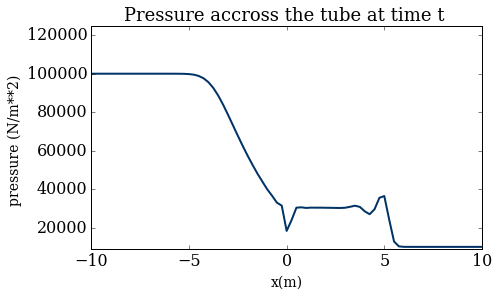

In [18]:
pression(s[2])

## Discussion sur les graphiques:

Nous observons que les graphiques des grandeurs calculées sont assez ressemblants aux graphiques des solutions analytiques données dans le module. Cela nous permet donc d'affirmer que nous avons là une étude correcte de l'évolution du gaz à travers le shock tube. Cependant, nous remarquons également que nos graphiques sont bien moins réguliers que les graphiques théoriques. Cela est dû à la discrètisation de la méthode. Aussi,notons que si nous négligeons ces irrégularités, nous obtenons exactement les mêmes formes de graphiques que celles du cours. Nous pouvons conclure que la méthode de richtmyer est acceptable mais qu'elle pourrait également être améliorée.

# Simulation Result:

***Enter all answers rounded to 2 decimal places:
Note, all answers are calculated at time t=0.01s***

*1°)Enter the velocity at x = 2.5 m in ms:*

Sachant que chaque pas spacial correspond à dx=0.25m, nous savons que l'indice dans le tableau des valeurs est 50 et puisque la vitesse est la deuxième ligne du tableau, il est aisé de sortir la valeur du tableau.

In [20]:
print s[1,50]

292.611471527


*2°)Enter the pressure at x = 2.5 m in Nm2:*

In [21]:
print s[2,50]

30250.8901676


*3°)Enter the density at x = 2.5 m in kg/m3:*

In [22]:
print s[0,50]

0.374691402648


Ces valeurs sont correctes, ce qui valide notre code.

# Evolution temporelle ##

Nous allons observer l'évolutions de la densité, de la vitesse et de la pression à différents instants. Commençons par regarder à un temps très proche du début : t=0.002 s

In [23]:
nt= 11

In [24]:
r1=richtmyer(h0,dt,dx,nt,nx)
s1=solution(r1)

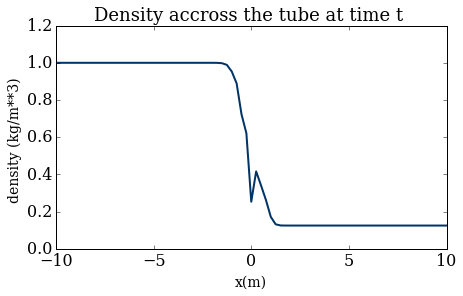

In [25]:
densite(s1[0])

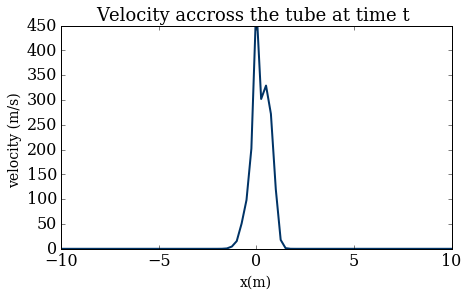

In [26]:
vitesse(s1[1])

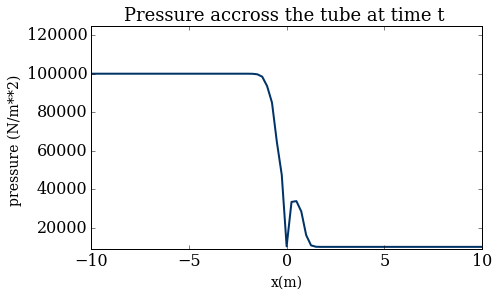

In [27]:
pression(s1[2])

Nous observons que les pics d'irrégularités apparaissent dès le début. Cela est dû à la discrétisation de la méthode que l'on utilise : c'est un défaut de la méthode.

Observons maintenant à un temps très avancé : t=0.016s.


Mais attention, on ne peut pas prendre un temps trop grand, au risque de propager l'onde au bord où nous avons fixé les conditions nous même, car la méthode ne permet pas de déterminer l'évolution aux extrémités.

In [28]:
nt = 81

In [29]:
r2=richtmyer(h0,dt,dx,nt,nx)
s2=solution(r2)

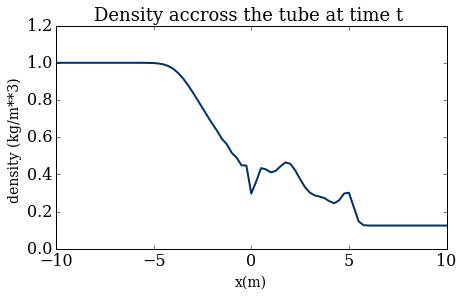

In [30]:
densite(s[0])

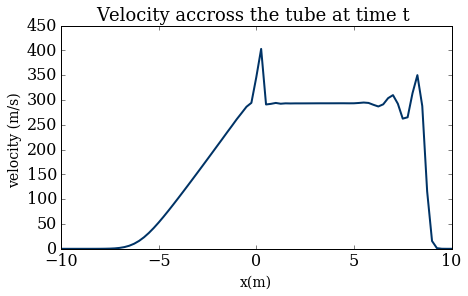

In [31]:
vitesse(s2[1])

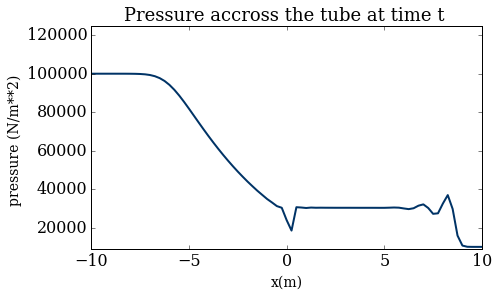

In [32]:
pression(s2[2])

Les observations sont en accord avec notre intuition physique : au cours de l'évolution dans le temps, le gaz tend à s'uniformiser dans le tube. Nous observons que nous n'avons plus que 2 paliers, et que la largeur des ondes s'est étendue. En revanche, nous avons toujours la présence des pics d'irrégularités (ce qui montre bien que c'est inhérent à la méthode).

# Conclusion

Le problème du shock tube nous a permis d'évaluer l'efficacité de la méthode de richtmyer en comparant la solution à la solution analytique. La méthode nous donne une solution globalement correcte, mais elle possède également des limites à cause de la discrètisation, d'où l'observation de pics d'irrégularités.